# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


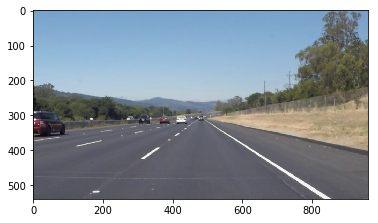

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    image_shape = img.shape
    max_x = image_shape[1]
    max_y = image_shape[0]
    #print("max_x = " + repr(max_x) + " max_y = " + repr(max_y))
    left_x1 = 0
    left_y1 = max_y
    right_x1 = max_x
    right_y1 = max_y
    left_x2 = max_x
    left_y2 = 0
    right_x2 = 0
    right_y2= 0
    for line in lines:
        # print ("Line: "+ repr(line))
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if slope > 0.2 and slope < 1.4:
                # Process right line
                if not is_good_right_line2(x1, x2, int(max_x * 0.48)):
                    print("Bad right line: slope: " + repr(slope) + " : "+ repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                    break
                #print("right slope " + repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                right_x1 = min(right_x1, x1, x2)
                right_y1 = min(right_y1, y1, y2)
                right_x2 = max(right_x2, x1, x2)
                right_y2 = max(right_y2, y1, y2)
            elif slope < -0.2 and slope > -1.4:
                # Process left line
                #if not is_good_left_line(x1, x2, min(right_x1, right_x2)):
                x_limit = int(max_x * 0.52)
                if not is_good_left_line2(x1, x2, x_limit):
                    print("Bad left line: slope:" + repr(slope) + "/" + repr(x_limit) + " : " + repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                    break
                #print("left slope " + repr(x1) + ", " + repr(y1) + " to " + repr(x2) + ", " + repr(y2))
                left_x1 = max(left_x1, x1, x2)
                left_y1 = min(left_y1, y1, y2)
                left_x2 = min(left_x2, x1, x2)
                left_y2 = max(left_y2, y1, y2)
            #print("Slope = " + repr(slope))
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    min_y = min(left_y1, right_y1)
    max_y = max(left_y2, right_y2)
    left_y1, left_x1, left_y2, left_x2 = extrapolate_line(left_y1, left_x1, left_y2, left_x2, min_y, max_y)
    right_y1, right_x1, right_y2, right_x2 = extrapolate_line(right_y1, right_x1, right_y2, right_x2, min_y, max_y)
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, 4*thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, 4*thickness)
    
def is_good_right_line2(right_x1, right_x2, x_limit):
    return right_x1 > x_limit or right_x2 > x_limit

def is_good_right_line(right_x1, right_x2, left_x):
    return right_x1 > left_x and right_x2 > left_x

def is_good_left_line2(left_x1, left_x2, right_x):
    return left_x1 < right_x or left_x2 < right_x

def is_good_left_line(left_x1, left_x2, right_x):
    return left_x1 < right_x and left_x2 < right_x
    
def extrapolate_line(low_y, low_x, high_y, high_x, min_y, max_y):
    """
     This routine extrapolates the given line so that both low_y and high_y hit min_y  and max_y respectively.
     low_x is the x value corresponding to the low_y where low_y < high_y.
     Similarly high_x is the x value corresponding to high_y such that high_y > low_y.
    """
    slope = ((high_y - low_y)/ (high_x - low_x))
    if (high_y < max_y):
        high_y = max_y
        high_x = int((high_y - low_y + slope*low_x) / slope)
    if (low_y > min_y):
        low_y = min_y
        low_x = int((low_y - high_y + slope * high_x) / slope)
    return low_y, low_x, high_y, high_x

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

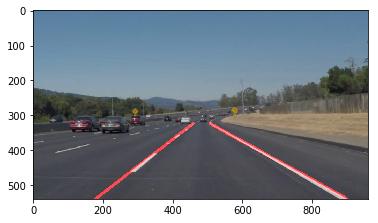

In [5]:


# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


def draw_lane_lines(image):
    image_gray = grayscale(image)
    kernel_size = 5
    image_blur = gaussian_blur(image_gray, kernel_size)
    image_canny = canny(image_blur, 80, 150)
    
    # Apply edge trimming.
    imshape = image_canny.shape
    left_bottom = (0.03 * imshape[1], imshape[0])
    left_top = (0.45 * imshape[1], 0.60 * imshape[0])
    right_top = ( 0.55 * imshape[1], 0.60 * imshape[0])
    right_bottom = (0.97 * imshape[1], imshape[0])
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    image_trimmed = region_of_interest(image_canny, vertices)
    
    # Apply hough transform.
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 4     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    image_hough = hough_lines(image_trimmed, rho, theta, threshold, min_line_length, max_line_gap)
    return weighted_img(image_hough, image)
    #return image_hough

def draw_lane_lines_for_filename(image_filename):
    image = mpimg.imread(image_filename)
    return draw_lane_lines(image)
    
#for i in os.listdir("test_images/"):
#    print ("File: " + repr(i))
#    draw_lane_lines_for_filename("test_images/" + i)
    
result = draw_lane_lines_for_filename("test_images/solidWhiteCurve.jpg")
plt.imshow(result)

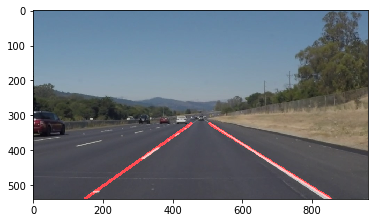

In [6]:

result2 = draw_lane_lines_for_filename("test_images/solidWhiteRight.jpg")
plt.imshow(result2)


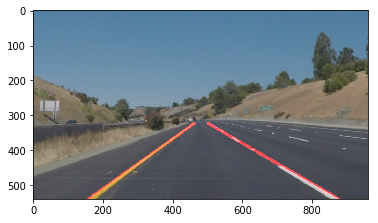

In [7]:
result4 = draw_lane_lines_for_filename("test_images/solidYellowCurve2.jpg")
plt.imshow(result4)

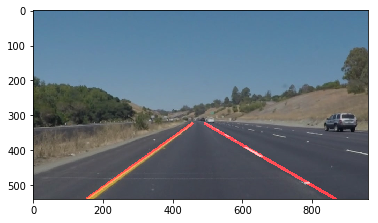

In [8]:
result3 = draw_lane_lines_for_filename("test_images/solidYellowCurve.jpg")
plt.imshow(result3)

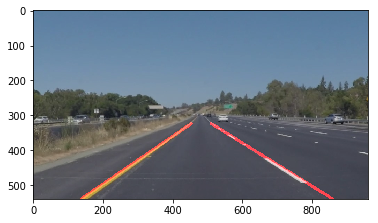

In [9]:
result4 = draw_lane_lines_for_filename("test_images/solidYellowLeft.jpg")
plt.imshow(result4)

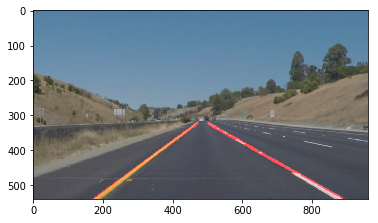

In [10]:
result5 = draw_lane_lines_for_filename("test_images/whiteCarLaneSwitch.jpg")
plt.imshow(result5)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = draw_lane_lines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 66.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.13 s, sys: 132 ms, total: 3.26 s
Wall time: 3.79 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  9%|▉         | 62/682 [00:00<00:08, 70.38it/s]

Bad right line: slope: 1.0333333333333334 : 157, 489 to 187, 520


 16%|█▋        | 111/682 [00:01<00:08, 64.14it/s]

Bad right line: slope: 0.78125 : 161, 485 to 193, 510


 18%|█▊        | 125/682 [00:01<00:08, 62.59it/s]

Bad right line: slope: 0.43333333333333335 : 172, 515 to 202, 528


 35%|███▍      | 238/682 [00:03<00:07, 61.48it/s]

Bad right line: slope: 0.27272727272727271 : 206, 497 to 239, 506


 42%|████▏     | 287/682 [00:04<00:06, 63.40it/s]

Bad right line: slope: 0.5 : 265, 433 to 295, 448


 44%|████▍     | 301/682 [00:04<00:06, 62.42it/s]

Bad right line: slope: 0.27272727272727271 : 162, 494 to 217, 509
Bad right line: slope: 0.29729729729729731 : 226, 488 to 263, 499
Bad right line: slope: 0.45161290322580644 : 374, 359 to 405, 373
Bad right line: slope: 1.1851851851851851 : 334, 376 to 361, 408


 48%|████▊     | 329/682 [00:05<00:05, 63.56it/s]

Bad right line: slope: 0.51515151515151514 : 231, 451 to 264, 468
Bad right line: slope: 0.47058823529411764 : 234, 448 to 268, 464


 49%|████▉     | 336/682 [00:05<00:05, 62.01it/s]

Bad right line: slope: 0.26470588235294118 : 181, 511 to 215, 520


 56%|█████▌    | 379/682 [00:05<00:04, 62.62it/s]

Bad left line: slope:-0.21212121212121213/499 : 741, 466 to 774, 459
Bad left line: slope:-0.32653061224489793/499 : 829, 530 to 878, 514


 81%|████████  | 550/682 [00:08<00:02, 62.99it/s]

Bad right line: slope: 0.23333333333333334 : 189, 508 to 219, 515
Bad right line: slope: 0.21875 : 185, 511 to 217, 518


 86%|████████▌ | 585/682 [00:09<00:01, 62.84it/s]

Bad right line: slope: 0.21875 : 255, 473 to 287, 480


 91%|█████████ | 620/682 [00:09<00:00, 62.08it/s]

Bad right line: slope: 0.4838709677419355 : 203, 523 to 234, 538
Bad right line: slope: 0.54545454545454541 : 259, 448 to 292, 466


 95%|█████████▌| 648/682 [00:10<00:00, 64.62it/s]

Bad right line: slope: 0.22222222222222221 : 229, 500 to 265, 508
Bad right line: slope: 0.34375 : 272, 440 to 304, 451


 98%|█████████▊| 669/682 [00:10<00:00, 62.36it/s]

Bad right line: slope: 0.81818181818181823 : 178, 486 to 211, 513
Bad left line: slope:-0.3125/499 : 668, 448 to 700, 438
Bad left line: slope:-0.22500000000000001/499 : 700, 469 to 740, 460


100%|█████████▉| 681/682 [00:10<00:00, 63.86it/s]

Bad left line: slope:-0.51515151515151514/499 : 801, 531 to 834, 514


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.77 s, sys: 408 ms, total: 10.2 s
Wall time: 11.1 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pipeline description

The pipeline works on individual images. In order to process a video, we just chop it down into individual images and process each image on its own. In the current implementation, there is no sharing of information between the processing of one image versus another. 

 Processing a single image:
    We first convert a given image into grayscale. We next apply the gaussian blur to reduce false positives for the edges. This helps with edge detection using the Canny OpenCV edge detection algorithm. We filter the detected edges through a pyramid shaped "region of interest". This is then passed into the Hough Transform to better detect longer edges that look like lane markers.
    
    The Hough transform outputs a set of lines, which we postprocess to create as output, two slanted lines would be the computed lane markers. 
    We compute this as follows:
    For each line we either label is as part of the 'left' or the 'right' lane marker or just discard it. This is done based on the slope and which half of the image the line is "majorly" part of.
    After this step we collect all the left lines separately, all the right lines seperately. For each set, we compute a "single" line thats representative of that set by looking at the average slope and min/max markers. We then "extraplote" this so that it "matches" the corresponding "right" lane candidate, thus creating two lane lines as output.
    

### Identify any shortcomings

* Lack of Information sharing between images:
   Some images are a bit harder to glean lane information from, simply because there are fewer lane markers, or dirt on the road, or obstruction due to traffic. But we can always combine information from previous and even subsequent images to "maintain" a "lane sense". 

* Dynamic learning of the "region" of interest. Since the cars move a bit, having a "fixed" region of interest does not work for all images that are part of a video. It would be nice to be able to go back and re-learn or tune a better region of interest dynamically for each image based on how good of a lane line it can produce.


### Suggest possible improvements

* Also it might be possible to build on work done by other cars by sharing lane determination meta-data indexed by location. Thus, when driving on a road, I could "preload" some datastructures or meta-information about lane detection for roads in the vicinity based on what other drivers have determined.

* Using a Neural Net for the lane detection might be more effective since it could train on lots of data and work around minor defects on the road etc.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  2%|▏         | 6/251 [00:00<00:04, 54.72it/s]

Bad right line: slope: 0.46511627906976744 : 547, 449 to 590, 469
Bad right line: slope: 0.56666666666666665 : 293, 666 to 323, 683


  8%|▊         | 19/251 [00:00<00:04, 56.16it/s]

Bad right line: slope: 0.58536585365853655 : 538, 453 to 579, 477
Bad right line: slope: 0.23529411764705882 : 408, 589 to 442, 597
Bad right line: slope: 0.2558139534883721 : 359, 623 to 402, 634
Bad right line: slope: 1.0217391304347827 : 325, 649 to 371, 696
Bad right line: slope: 0.52380952380952384 : 308, 661 to 371, 694
Bad right line: slope: 0.63636363636363635 : 316, 654 to 360, 682
Bad right line: slope: 0.39393939393939392 : 309, 659 to 342, 672


 16%|█▌        | 39/251 [00:00<00:03, 57.57it/s]

Bad left line: slope:-0.28947368421052633/665 : 1037, 676 to 1075, 665
Bad right line: slope: 0.34285714285714286 : 291, 667 to 326, 679
Bad right line: slope: 0.21875 : 422, 573 to 454, 580
Bad left line: slope:-0.37142857142857144/665 : 1029, 677 to 1064, 664


 18%|█▊        | 45/251 [00:00<00:03, 56.24it/s]

Bad right line: slope: 0.35483870967741937 : 447, 536 to 478, 547
Bad right line: slope: 0.5 : 430, 544 to 462, 560
Bad right line: slope: 0.23333333333333334 : 419, 580 to 449, 587
Bad left line: slope:-0.21212121212121213/665 : 1056, 678 to 1089, 671
Bad right line: slope: 0.69999999999999996 : 335, 638 to 365, 659
Bad right line: slope: 0.54285714285714282 : 327, 644 to 362, 663
Bad right line: slope: 0.61764705882352944 : 332, 641 to 366, 662


 22%|██▏       | 56/251 [00:01<00:04, 40.00it/s]

Bad left line: slope:-0.25/665 : 1044, 678 to 1076, 670
Bad left line: slope:-0.23529411764705882/665 : 1049, 678 to 1083, 670
Bad right line: slope: 0.59523809523809523 : 572, 434 to 614, 459
Bad right line: slope: 0.87878787878787878 : 574, 433 to 607, 462
Bad right line: slope: 0.34999999999999998 : 374, 610 to 414, 624


 31%|███       | 77/251 [00:01<00:04, 37.03it/s]

Bad right line: slope: 0.83333333333333337 : 395, 567 to 425, 592
Bad right line: slope: 0.80645161290322576 : 572, 437 to 603, 462
Bad right line: slope: 0.34375 : 370, 620 to 402, 631


 34%|███▍      | 85/251 [00:01<00:04, 35.21it/s]

Bad right line: slope: 1.024390243902439 : 332, 655 to 373, 697
Bad right line: slope: 1.375 : 338, 651 to 370, 695
Bad right line: slope: 0.91428571428571426 : 566, 437 to 601, 469
Bad right line: slope: 0.72972972972972971 : 569, 438 to 606, 465
Bad right line: slope: 0.40000000000000002 : 451, 545 to 481, 557
Bad right line: slope: 0.28888888888888886 : 484, 506 to 529, 519
Bad right line: slope: 1.3043478260869565 : 585, 434 to 608, 464
Bad right line: slope: 0.71052631578947367 : 572, 434 to 610, 461
Bad right line: slope: 0.65714285714285714 : 467, 517 to 502, 540


 37%|███▋      | 93/251 [00:02<00:04, 32.95it/s]

Bad right line: slope: 1.1379310344827587 : 572, 434 to 601, 467
Bad right line: slope: 0.31428571428571428 : 320, 670 to 355, 681
Bad right line: slope: 0.65306122448979587 : 328, 665 to 377, 697
Bad right line: slope: 0.38095238095238093 : 442, 543 to 484, 559
Bad right line: slope: 0.22580645161290322 : 506, 508 to 537, 515
Bad right line: slope: 0.77551020408163263 : 455, 540 to 504, 578
Bad right line: slope: 0.54347826086956519 : 418, 574 to 464, 599
Bad right line: slope: 1.1538461538461537 : 454, 509 to 493, 554
Bad right line: slope: 0.90909090909090906 : 451, 509 to 495, 549
Bad right line: slope: 0.37777777777777777 : 456, 529 to 501, 546
Bad right line: slope: 0.94117647058823528 : 354, 648 to 388, 680
Bad right line: slope: 0.5 : 406, 533 to 438, 549
Bad right line: slope: 0.23809523809523808 : 484, 514 to 526, 524
Bad right line: slope: 0.51219512195121952 : 439, 541 to 480, 562


 39%|███▊      | 97/251 [00:02<00:04, 33.55it/s]

Bad right line: slope: 0.84615384615384615 : 409, 555 to 448, 588
Bad right line: slope: 1.2058823529411764 : 464, 523 to 498, 564
Bad right line: slope: 0.9642857142857143 : 316, 643 to 372, 697
Bad right line: slope: 0.36842105263157893 : 205, 631 to 243, 645
Bad right line: slope: 0.80434782608695654 : 404, 549 to 450, 586
Bad right line: slope: 0.32258064516129031 : 221, 630 to 252, 640
Bad right line: slope: 0.43243243243243246 : 218, 630 to 255, 646
Bad right line: slope: 0.43243243243243246 : 224, 630 to 261, 646
Bad right line: slope: 1.3428571428571427 : 473, 516 to 508, 563
Bad right line: slope: 1.2361111111111112 : 439, 509 to 511, 598
Bad right line: slope: 0.47727272727272729 : 351, 563 to 395, 584
Bad right line: slope: 0.21052631578947367 : 329, 648 to 367, 656
Bad right line: slope: 0.29411764705882354 : 222, 659 to 256, 669
Bad right line: slope: 0.625 : 363, 563 to 395, 583
Bad right line: slope: 0.22500000000000001 : 326, 648 to 366, 657
Bad right line: slope: 0.205

 42%|████▏     | 105/251 [00:02<00:04, 33.38it/s]

Bad left line: slope:-0.20634920634920634/665 : 770, 514 to 833, 501
Bad right line: slope: 0.33333333333333331 : 309, 668 to 339, 678
Bad right line: slope: 0.25 : 228, 637 to 260, 645
Bad left line: slope:-0.22807017543859648/665 : 887, 578 to 944, 565
Bad left line: slope:-0.21875/665 : 701, 579 to 733, 572
Bad left line: slope:-0.34285714285714286/665 : 803, 593 to 838, 581
Bad left line: slope:-0.21875/665 : 726, 574 to 758, 567
Bad left line: slope:-0.23529411764705882/665 : 861, 582 to 912, 570
Bad left line: slope:-1.2258064516129032/665 : 794, 595 to 825, 557
Bad left line: slope:-0.22500000000000001/665 : 669, 666 to 709, 657
Bad left line: slope:-0.21052631578947367/665 : 840, 621 to 954, 597
Bad left line: slope:-0.22857142857142856/665 : 768, 586 to 803, 578
Bad left line: slope:-0.22988505747126436/665 : 712, 653 to 799, 633
Bad left line: slope:-0.21276595744680851/665 : 811, 590 to 858, 580
Bad left line: slope:-0.21276595744680851/665 : 930, 598 to 977, 588
Bad right l

 45%|████▌     | 113/251 [00:02<00:04, 32.39it/s]

Bad left line: slope:-0.22500000000000001/665 : 786, 611 to 826, 602
Bad left line: slope:-0.56521739130434778/665 : 670, 648 to 716, 622
Bad left line: slope:-0.32307692307692309/665 : 873, 666 to 938, 645
Bad left line: slope:-0.45000000000000001/665 : 780, 629 to 820, 611
Bad left line: slope:-0.33636363636363636/665 : 929, 649 to 1039, 612
Bad left line: slope:-0.77777777777777779/665 : 854, 620 to 890, 592
Bad left line: slope:-0.28205128205128205/665 : 943, 647 to 982, 636
Bad left line: slope:-0.26315789473684209/665 : 783, 610 to 821, 600
Bad left line: slope:-0.32500000000000001/665 : 962, 641 to 1002, 628
Bad left line: slope:-0.33333333333333331/665 : 780, 605 to 813, 594
Bad left line: slope:-0.52083333333333337/665 : 1064, 676 to 1112, 651
Bad left line: slope:-0.33333333333333331/665 : 796, 630 to 832, 618
Bad left line: slope:-1.3333333333333333/665 : 814, 666 to 844, 626
Bad left line: slope:-1.0606060606060606/665 : 923, 673 to 956, 638
Bad left line: slope:-1.11764705

 50%|████▉     | 125/251 [00:03<00:03, 32.33it/s]

Bad right line: slope: 0.25 : 357, 630 to 393, 639


 55%|█████▍    | 137/251 [00:03<00:03, 29.11it/s]

Bad right line: slope: 0.375 : 560, 446 to 592, 458
Bad right line: slope: 0.42105263157894735 : 554, 445 to 592, 461
Bad right line: slope: 0.5 : 542, 451 to 574, 467


 58%|█████▊    | 145/251 [00:03<00:03, 29.63it/s]

Bad right line: slope: 0.3125 : 525, 494 to 557, 504
Bad left line: slope:-0.69444444444444442/665 : 668, 530 to 704, 505
Bad right line: slope: 0.46666666666666667 : 512, 482 to 557, 503
Bad left line: slope:-0.72499999999999998/665 : 673, 541 to 713, 512
Bad left line: slope:-0.52941176470588236/665 : 708, 559 to 742, 541
Bad left line: slope:-1.2916666666666667/665 : 956, 613 to 980, 582
Bad right line: slope: 0.33333333333333331 : 287, 656 to 317, 666
Bad left line: slope:-0.29411764705882354/665 : 868, 556 to 902, 546
Bad left line: slope:-0.27027027027027029/665 : 871, 557 to 908, 547


 59%|█████▉    | 149/251 [00:04<00:03, 29.68it/s]

Bad right line: slope: 1.0416666666666667 : 446, 546 to 494, 596
Bad left line: slope:-0.73529411764705888/665 : 678, 573 to 712, 548
Bad right line: slope: 0.23076923076923078 : 450, 506 to 502, 518
Bad left line: slope:-0.92307692307692313/665 : 730, 668 to 769, 632
Bad right line: slope: 0.83673469387755106 : 363, 560 to 412, 601
Bad right line: slope: 0.41463414634146339 : 348, 561 to 389, 578
Bad left line: slope:-1.3611111111111112/665 : 691, 635 to 727, 586
Bad right line: slope: 1.05 : 375, 574 to 415, 616
Bad right line: slope: 0.61111111111111116 : 322, 575 to 376, 608
Bad right line: slope: 0.42857142857142855 : 484, 594 to 519, 609
Bad left line: slope:-0.22916666666666666/665 : 736, 616 to 784, 605
Bad right line: slope: 0.2413793103448276 : 319, 582 to 377, 596
Bad left line: slope:-0.30769230769230771/665 : 731, 616 to 770, 604
Bad right line: slope: 0.30769230769230771 : 355, 597 to 394, 609
Bad right line: slope: 0.2857142857142857 : 450, 600 to 485, 610
Bad right line

 63%|██████▎   | 157/251 [00:04<00:03, 30.42it/s]

Bad right line: slope: 0.88571428571428568 : 350, 572 to 385, 603
Bad right line: slope: 0.38709677419354838 : 382, 586 to 413, 598
Bad right line: slope: 0.27027027027027029 : 439, 523 to 476, 533
Bad right line: slope: 0.39393939393939392 : 421, 535 to 454, 548
Bad right line: slope: 0.4375 : 419, 535 to 451, 549
Bad right line: slope: 0.4838709677419355 : 238, 668 to 269, 683


 67%|██████▋   | 169/251 [00:04<00:02, 30.23it/s]

Bad right line: slope: 0.25 : 285, 644 to 325, 654


 71%|███████   | 177/251 [00:04<00:02, 29.68it/s]

Bad right line: slope: 0.23333333333333334 : 464, 530 to 494, 537
Bad right line: slope: 0.21621621621621623 : 351, 621 to 388, 629


 76%|███████▌  | 190/251 [00:05<00:02, 28.37it/s]

Bad right line: slope: 1.2250000000000001 : 341, 632 to 381, 681


 81%|████████  | 203/251 [00:05<00:01, 28.51it/s]

Bad right line: slope: 0.32258064516129031 : 302, 673 to 333, 683


 86%|████████▌ | 215/251 [00:06<00:01, 30.98it/s]

Bad right line: slope: 0.51428571428571423 : 421, 558 to 456, 576
Bad right line: slope: 0.45161290322580644 : 315, 668 to 346, 682
Bad right line: slope: 0.20512820512820512 : 414, 594 to 453, 602
Bad right line: slope: 0.20512820512820512 : 410, 597 to 449, 605
Bad right line: slope: 1.2571428571428571 : 341, 653 to 376, 697
Bad right line: slope: 0.46666666666666667 : 318, 669 to 348, 683


 90%|█████████ | 227/251 [00:06<00:00, 32.57it/s]

Bad right line: slope: 0.46875 : 407, 605 to 439, 620
Bad right line: slope: 0.20408163265306123 : 337, 657 to 386, 667
Bad right line: slope: 0.2978723404255319 : 345, 651 to 392, 665


 97%|█████████▋| 244/251 [00:07<00:00, 34.97it/s]

Bad right line: slope: 0.4375 : 318, 669 to 350, 683
Bad right line: slope: 0.43333333333333335 : 317, 670 to 347, 683
Bad right line: slope: 0.34375 : 377, 619 to 409, 630


100%|██████████| 251/251 [00:07<00:00, 34.31it/s]

Bad right line: slope: 0.40000000000000002 : 337, 667 to 372, 681


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.22 s, sys: 252 ms, total: 5.47 s
Wall time: 8.14 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))